In [173]:
import skimage
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

from plot_helpers import show_image

## K-Means Colour Clustering

In [87]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')
x = npzfile['x']
y = npzfile['y']

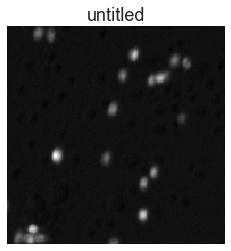

In [90]:
show_image(x[3])

In [142]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [225]:
green_img = np.reshape(x[3], (192*192, 1))

In [226]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(green_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [227]:
center = np.uint8(center)

In [228]:
res = center[label.flatten()]
green_result = res.reshape((192, 192))

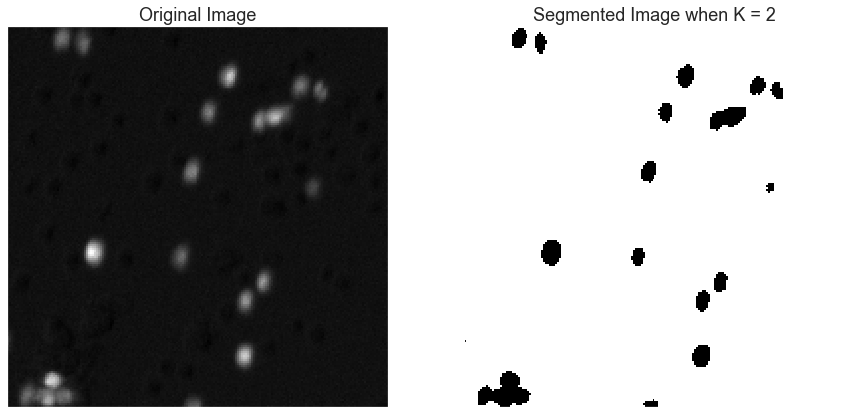

In [229]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[3], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [230]:
red_img = np.reshape(x[103], (192*192, 1))

In [189]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(red_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [190]:
center = np.uint8(center)

In [191]:
res = center[label.flatten()]
red_result = res.reshape((192, 192))

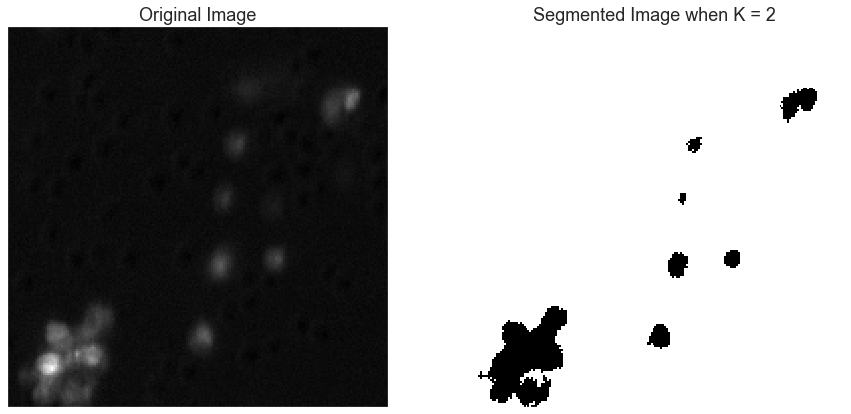

In [192]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(red_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [234]:
kmeans = KMeans(K).fit(green_img)

In [239]:
res = kmeans.cluster_centers_[kmeans.labels_]
green_result_2 = res.reshape((192, 192))

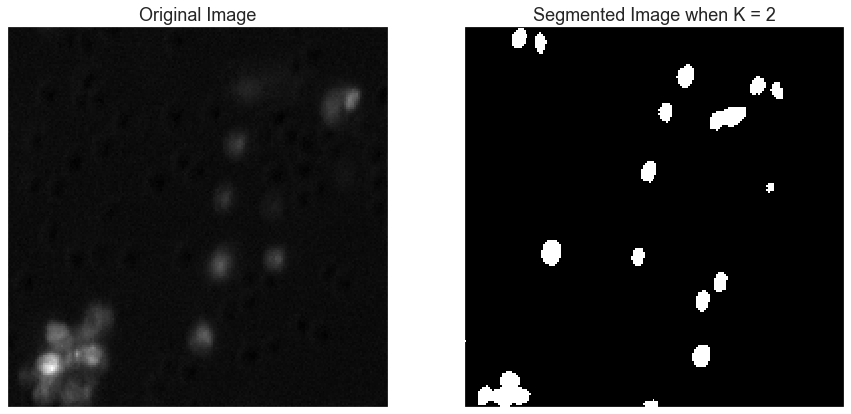

In [240]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result_2, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [241]:
np.unique(green_result_2)

array([210.94331, 522.56195], dtype=float32)

In [270]:
def get_mask(img):
    kmeans = KMeans(K).fit(img.reshape(np.prod(img.shape), 1))
    return convert_to_binary(kmeans.cluster_centers_[kmeans.labels_])

In [273]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    mask = np.copy(a)
    for idx, pixel in enumerate(a):
        if pixel == val:
            mask[idx] = 1
        else:
            mask[idx] = 0
    return mask.astype(np.uint8)

In [274]:
green = get_mask(x[3])

In [275]:
red = get_mask(x[103])

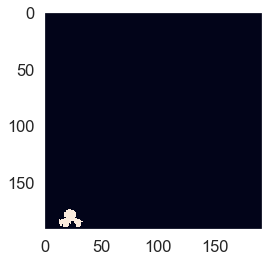

In [281]:
plt.imshow(np.reshape(green & red, (192, 192)))
plt.grid(False)

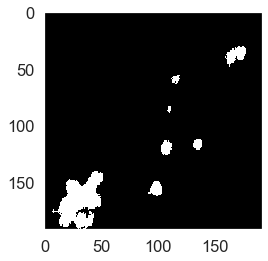

In [280]:
plt.imshow(red.reshape(192, 192), cmap="gray")
plt.grid(False)

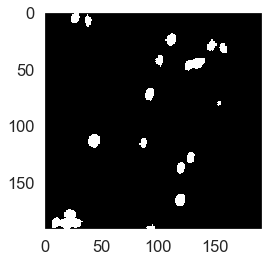

In [279]:
plt.imshow(green.reshape(192, 192), cmap="gray")
plt.grid(False)

## Intersection over union

In [63]:
# using skimage.draw.circle
c1 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c1.shape[1]/3, r=c1.shape[0]/2, radius=10)
c1[r,c]=1

In [79]:
# using skimage.draw.circle
c2 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c2.shape[1]/2, r=c2.shape[0]/2, radius=11)
c2[r,c]=1

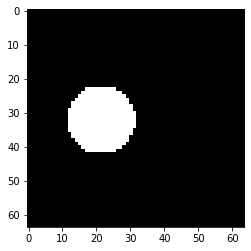

In [80]:
plt.imshow(c1, cmap="gray")

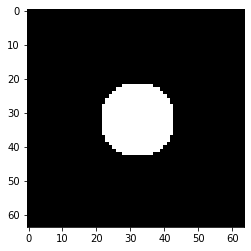

In [81]:
plt.imshow(c2, cmap="gray")

In [49]:
a = np.array([1, 0, 1])
b = np.array([0, 0, 1])

In [83]:
np.sum(c2 == 1)

373

In [52]:
c1.astype("bool")

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [74]:
t = c1.astype("bool") & c2.astype("bool")

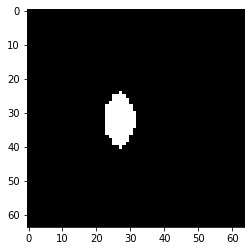

In [78]:
plt.imshow(t.astype("uint8"), cmap="gray")

In [84]:
np.sum(t == True)

109

In [86]:
109/(310+373)

0.1595900439238653

In [46]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


if __name__ == '__main__':
    # Pointing out a wrong IoU implementation in https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    boxA = [0., 0., 10., 10.]
    boxB = [1., 1., 11., 11.]

    correct = bb_intersection_over_union(boxA, boxB)
    print('Correct solution - also analytical: {0}\n'
          'Solution by published function: {1}\n'
          'Solution by correction (ptyshevs): {2}\n'.format(correct, '0.704225352113', '0.680672268908'))

    print('Normalizing coordinates in a 100x100 coordinate system')
    boxA = [a / 100. for a in boxA]
    boxB = [b / 100. for b in boxB]

    correct = bb_intersection_over_union(boxA, boxB)

    print('Correct solution - also analytical: {0}\n'
          'Solution by published function: {1}\n'
          'Solution by correction: {2}\n'.format(correct, '0.964445166004', '0.680672268908'))
    
    print('Two boxes with no overlap')
    boxA = [0., 0., 10., 10.]
    boxB = [12., 12., 22., 22.]
    correct = bb_intersection_over_union(boxA, boxB)

    print('Correct solution - also analytical: {0}\n'
          'Solution by published function: {1}\n'
          'Solution by correction (ptyshevs): {2}\n'.format(correct, '0.0', '0.0204081632653'))


    print('Example in the comments from ptyshevs')
    boxA = [0., 0., 2., 2.]
    boxB = [1., 1., 3., 3.]
    correct = bb_intersection_over_union(boxA, boxB)

    print('Correct solution - also analytical: {0}\n'
          'Solution by published function: {1}\n'
          'Solution by correction (ptyshevs): {2}\n'.format(correct, '0.285714285714', '0.142857142857'))

Correct solution - also analytical: 0.680672268907563
Solution by published function: 0.704225352113
Solution by correction (ptyshevs): 0.680672268908

Normalizing coordinates in a 100x100 coordinate system
Correct solution - also analytical: 0.6806722689075629
Solution by published function: 0.964445166004
Solution by correction: 0.680672268908

Two boxes with no overlap
Correct solution - also analytical: 0
Solution by published function: 0.0
Solution by correction (ptyshevs): 0.0204081632653

Example in the comments from ptyshevs
Correct solution - also analytical: 0.14285714285714285
Solution by published function: 0.285714285714
Solution by correction (ptyshevs): 0.142857142857

